<a href="https://colab.research.google.com/github/ritikashinde/CodeClaudeInternship_retail-demand-forecasting/blob/main/retail_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

Loading and Cleaning Data

In [ ]:
df = pd.read_csv("retail_store_inventory.csv")
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
df.info()
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
print("Column Names:")
print(df.columns.tolist())



Column Names:
['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']


In [ ]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Check again
print(df.columns.tolist())



['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']


In [ ]:
print(df[['Date', 'Units Sold']].head(10))


         Date  Units Sold
0  2022-01-01         127
1  2022-01-01         150
2  2022-01-01          65
3  2022-01-01          61
4  2022-01-01          14
5  2022-01-01         128
6  2022-01-01          97
7  2022-01-01         312
8  2022-01-01         175
9  2022-01-01          28


In [ ]:
df['Units Sold'] = pd.to_numeric(df['Units Sold'], errors='coerce')
print(df['Units Sold'].describe())


count    73100.000000
mean       136.464870
std        108.919406
min          0.000000
25%         49.000000
50%        107.000000
75%        203.000000
max        499.000000
Name: Units Sold, dtype: float64


Visualizing the Trend

Any invalid dates? 0
            Units Sold
Date                  
2022-01-01       14484
2022-01-02       13415
2022-01-03       13681
2022-01-04       14084
2022-01-05       12572


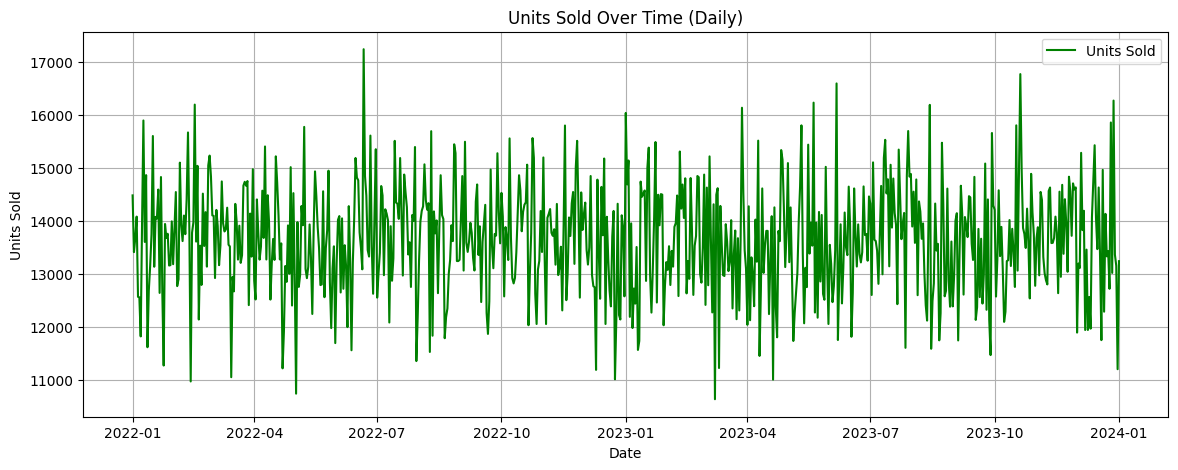

In [ ]:
# Step 1: converting 'Date' string into datetime constraint
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Confirm all dates are valid
print("Any invalid dates?", df['Date'].isna().sum())

# Step 3: Drop rows with invalid dates
df = df.dropna(subset=['Date'])

# Step 4: Group by Date
df_grouped = df.groupby(df['Date'].dt.date).agg({'Units Sold': 'sum'}).reset_index()

# Step 5: Set Date as datetime index and convert to daily frequency
df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
df_grouped.set_index('Date', inplace=True)
df_grouped = df_grouped.sort_index()

# Step 6: Reindex to daily frequency and interpolate
df_grouped = df_grouped.asfreq('D')
df_grouped['Units Sold'] = df_grouped['Units Sold'].interpolate(method='linear')

# Step 7: Confirm and plot
print(df_grouped.head())

plt.figure(figsize=(14, 5))
plt.plot(df_grouped.index, df_grouped['Units Sold'], color='green', label='Units Sold')
plt.title('Units Sold Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.grid(True)
plt.legend()
plt.show()


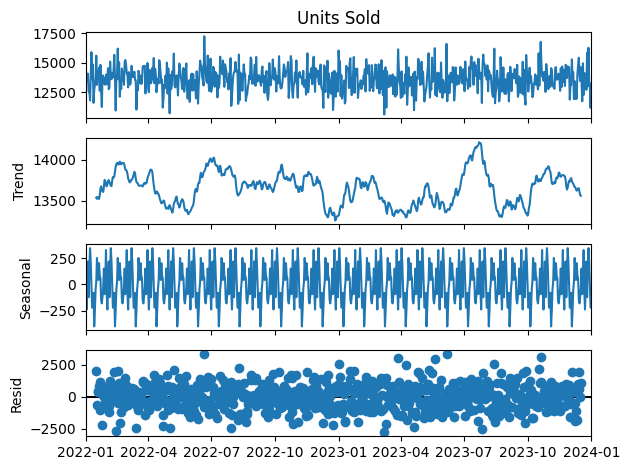

In [19]:
# Decompose the time series
decomp = seasonal_decompose(df_grouped['Units Sold'], model='additive', period=30)
decomp.plot()
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7xh07oe/u3_3ml_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph7xh07oe/o6q71blk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4833', 'data', 'file=/tmp/tmph7xh07oe/u3_3ml_o.json', 'init=/tmp/tmph7xh07oe/o6q71blk.json', 'output', 'file=/tmp/tmph7xh07oe/prophet_modeldorhwzvj/prophet_model-20250513085843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


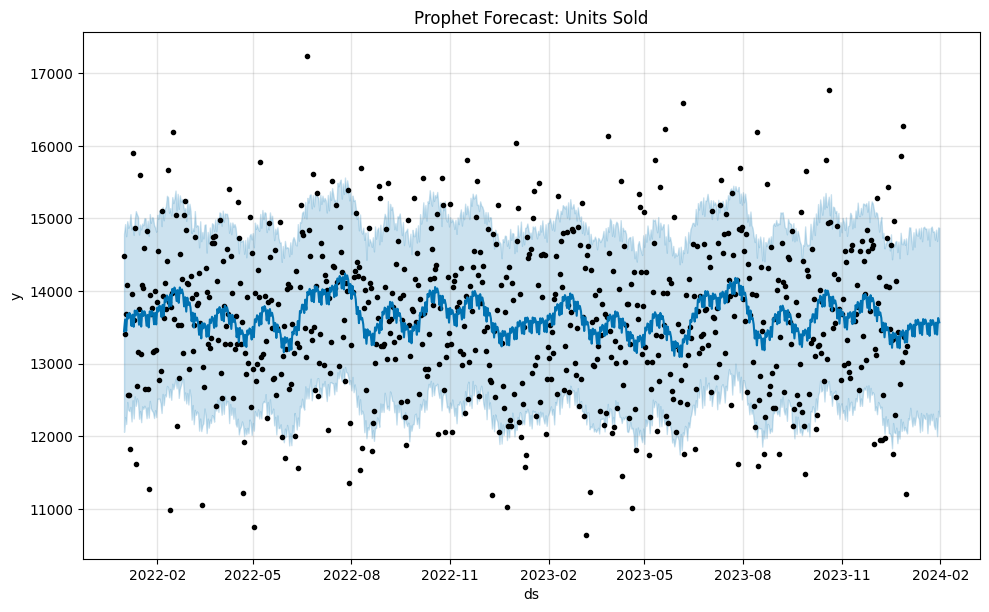

In [20]:
# Prepare data for Prophet
prophet_df = df_grouped.reset_index()[['Date', 'Units Sold']]
prophet_df.columns = ['ds', 'y']

# Train Prophet model
model = Prophet()
model.fit(prophet_df)

# Forecast for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast: Units Sold")
plt.show()


In [21]:
# Compare actual vs predicted on known data
merged = pd.merge(forecast[['ds', 'yhat']], prophet_df, how='inner', on='ds')
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 796.33
RMSE: 1004.95


Visually comparing prophet's forecast with actual values

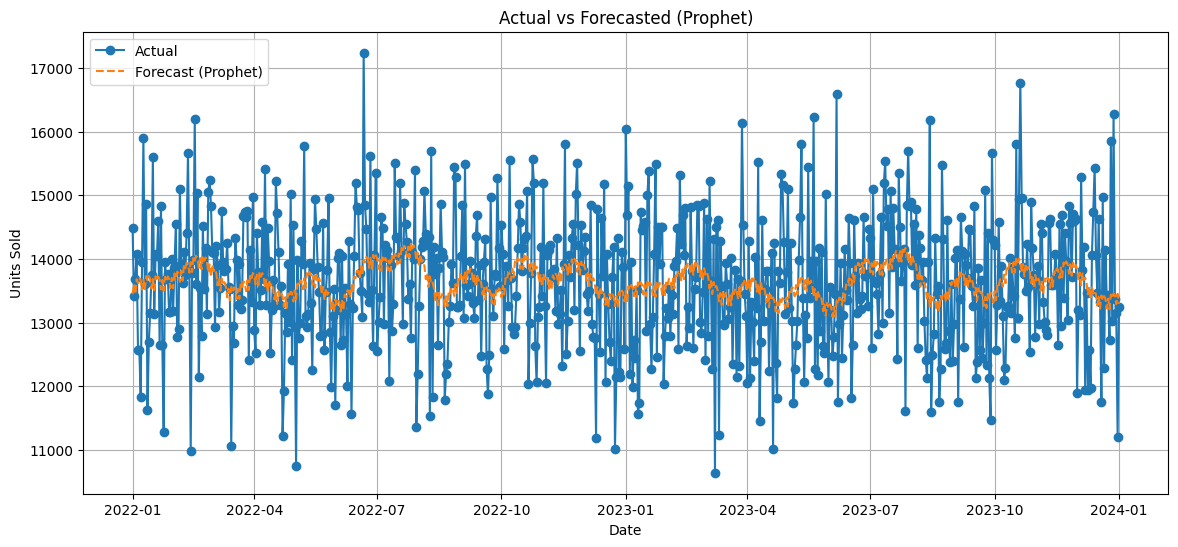

In [24]:
plt.figure(figsize=(14,6))
plt.plot(merged['ds'], merged['y'], label='Actual', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Forecast (Prophet)', linestyle='--')
plt.title('Actual vs Forecasted (Prophet)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


 Plot Full Forecast (Historical + Next 30 Days)

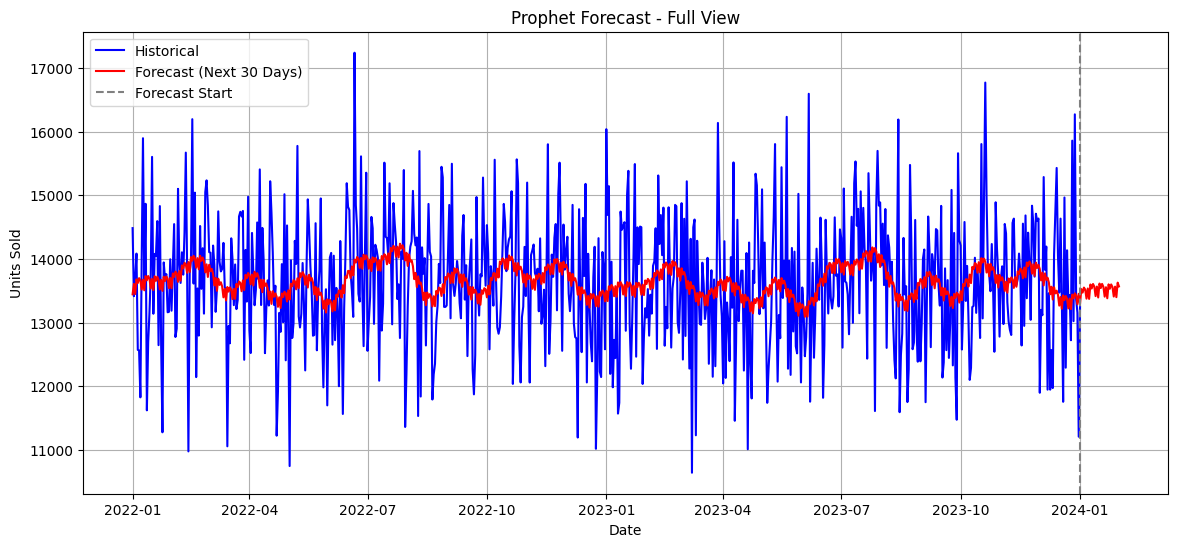

In [25]:
plt.figure(figsize=(14,6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Next 30 Days)', color='red')
plt.axvline(x=prophet_df['ds'].max(), color='gray', linestyle='--', label='Forecast Start')
plt.title('Prophet Forecast - Full View')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Save to main CSV file
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_forecast_units_sold.csv', index=False)
